## Import packages

In [1]:

import pandas as pd
import tensorflow as tf
import numpy as np

In [2]:
data = pd.read_csv('train.csv')
data

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,0000997932d777bf,Explanation\nWhy the edits made under my usern...,0,0,0,0,0,0
1,000103f0d9cfb60f,D'aww! He matches this background colour I'm s...,0,0,0,0,0,0
2,000113f07ec002fd,"Hey man, I'm really not trying to edit war. It...",0,0,0,0,0,0
3,0001b41b1c6bb37e,"""\nMore\nI can't make any real suggestions on ...",0,0,0,0,0,0
4,0001d958c54c6e35,"You, sir, are my hero. Any chance you remember...",0,0,0,0,0,0
...,...,...,...,...,...,...,...,...
159566,ffe987279560d7ff,""":::::And for the second time of asking, when ...",0,0,0,0,0,0
159567,ffea4adeee384e90,You should be ashamed of yourself \n\nThat is ...,0,0,0,0,0,0
159568,ffee36eab5c267c9,"Spitzer \n\nUmm, theres no actual article for ...",0,0,0,0,0,0
159569,fff125370e4aaaf3,And it looks like it was actually you who put ...,0,0,0,0,0,0


In [3]:
data.tail()

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
159566,ffe987279560d7ff,""":::::And for the second time of asking, when ...",0,0,0,0,0,0
159567,ffea4adeee384e90,You should be ashamed of yourself \n\nThat is ...,0,0,0,0,0,0
159568,ffee36eab5c267c9,"Spitzer \n\nUmm, theres no actual article for ...",0,0,0,0,0,0
159569,fff125370e4aaaf3,And it looks like it was actually you who put ...,0,0,0,0,0,0
159570,fff46fc426af1f9a,"""\nAnd ... I really don't think you understand...",0,0,0,0,0,0


## Preprocess

In [4]:
from tensorflow.keras.layers import TextVectorization

In [5]:
X = data['comment_text']
y = data[data.columns[2:]].values

In [6]:
MAX_FEATURES = 200000 # number of words in the vocab

In [15]:
vectorizer = TextVectorization(max_tokens=MAX_FEATURES,
                               output_sequence_length=100, # here i take small output sequence length because its show error of out of memory 
                               output_mode='int')

In [16]:

vectorizer.adapt(X.values)

In [21]:
vectorized_text = vectorizer(X.values)

In [24]:
#MCSHBAP - map, chache, shuffle, batch, prefetch  from_tensor_slices, list_file
dataset = tf.data.Dataset.from_tensor_slices((vectorized_text, y))
dataset = dataset.cache()
dataset = dataset.shuffle(160000)
dataset = dataset.batch(16)
dataset = dataset.prefetch(8) # helps bottlenecks

In [25]:
train = dataset.take(int(len(dataset)*.7))
val = dataset.skip(int(len(dataset)*.7)).take(int(len(dataset)*.2))
test = dataset.skip(int(len(dataset)*.9)).take(int(len(dataset)*.1))

## Create Sequential Model

In [26]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dropout, Bidirectional, Dense, Embedding

In [29]:
model = Sequential()
# Create the embedding layer 
model.add(Embedding(MAX_FEATURES+1, 32))
# Bidirectional LSTM Layer
model.add(Bidirectional(LSTM(32, activation='tanh')))
# Feature extractor Fully connected layers
model.add(Dense(128, activation='relu'))
model.add(Dense(256, activation='relu'))
model.add(Dense(128, activation='relu'))
# Final layer 
model.add(Dense(6, activation='sigmoid'))

In [32]:
model.compile(loss='BinaryCrossentropy', optimizer='Adam')

In [33]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, None, 32)          6400032   
                                                                 
 bidirectional_1 (Bidirectio  (None, 64)               16640     
 nal)                                                            
                                                                 
 dense_4 (Dense)             (None, 128)               8320      
                                                                 
 dense_5 (Dense)             (None, 256)               33024     
                                                                 
 dense_6 (Dense)             (None, 128)               32896     
                                                                 
 dense_7 (Dense)             (None, 6)                 774       
                                                      

In [34]:
history = model.fit(train, epochs=1, validation_data=val)

6981/6981 [==============================] - 1227s 175ms/step - loss: 0.0629 - val_loss: 0.0476


In [37]:
history.history

{'loss': [0.06285154819488525], 'val_loss': [0.04756396263837814]}

In [38]:
from matplotlib import pyplot as plt

<Figure size 576x360 with 0 Axes>

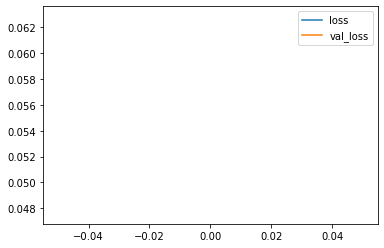

In [39]:
plt.figure(figsize=(8,5))
pd.DataFrame(history.history).plot()
plt.show()

## Make Predictions

In [40]:
input_text = vectorizer('You freaking suck! I am going to hit you.')

In [44]:
res = model.predict(np.array([input_text]))

In [45]:
res

array([[0.9547896 , 0.15223509, 0.8018272 , 0.0552991 , 0.6563002 ,
        0.14668202]], dtype=float32)

In [46]:
(res > 0.5).astype(int)

array([[1, 0, 1, 0, 1, 0]])

In [47]:
batch_X, batch_y = test.as_numpy_iterator().next()

In [48]:
(model.predict(batch_X) > 0.5).astype(int)

array([[0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [1, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [1, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0]])

In [49]:
res.shape

(1, 6)

## Evaluate Model

In [50]:
from tensorflow.keras.metrics import Precision, Recall, CategoricalAccuracy

In [51]:
pre = Precision()
re = Recall()
acc = CategoricalAccuracy()

In [52]:
for batch in test.as_numpy_iterator(): 
    # Unpack the batch 
    X_true, y_true = batch
    # Make a prediction 
    yhat = model.predict(X_true)
    
    # Flatten the predictions
    y_true = y_true.flatten()
    yhat = yhat.flatten()
    
    pre.update_state(y_true, yhat)
    re.update_state(y_true, yhat)
    acc.update_state(y_true, yhat)

In [53]:
print(f'Precision: {pre.result().numpy()}, Recall:{re.result().numpy()}, Accuracy:{acc.result().numpy()}') # we get definetly get  better accuracy i didnt do so many epochs of my computer so slow 

Precision: 0.8649193644523621, Recall:0.6013456583023071, Accuracy:0.4774323105812073


## Test and Gradio

In [54]:
import tensorflow as tf
import gradio as gr

In [55]:
model.save('toxicity.h5')

In [56]:
model = tf.keras.models.load_model('toxicity.h5')

In [57]:
input_str = vectorizer('hey i freaken hate you!')

In [58]:
res = model.predict(np.expand_dims(input_str,0))

In [59]:
res

array([[0.7440855 , 0.03348729, 0.27548623, 0.03696546, 0.39194098,
        0.08108625]], dtype=float32)

In [60]:
def score_comment(comment):
    vectorized_comment = vectorizer([comment])
    results = model.predict(vectorized_comment)
    
    text = ''
    for idx, col in enumerate(df.columns[2:]):
        text += '{}: {}\n'.format(col, results[0][idx]>0.5)
    
    return text

In [61]:
interface = gr.Interface(fn=score_comment, 
                         inputs=gr.inputs.Textbox(lines=2, placeholder='Comment to score'),
                        outputs='text')

C:\Users\shyam suthar\anaconda3\lib\site-packages\gradio\deprecation.py:40: UserWarning: `optional` parameter is deprecated, and it has no effect
  warnings.warn(value)
C:\Users\shyam suthar\anaconda3\lib\site-packages\gradio\deprecation.py:40: UserWarning: `numeric` parameter is deprecated, and it has no effect
  warnings.warn(value)
C:\Users\shyam suthar\anaconda3\lib\site-packages\gradio\deprecation.py:40: UserWarning: The 'type' parameter has been deprecated. Use the Number component instead.
  warnings.warn(value)


In [62]:
interface.launch(share=True)

Running on local URL:  http://127.0.0.1:7860/
Running on public URL: https://18780.gradio.app

This share link expires in 72 hours. For free permanent hosting, check out Spaces (https://huggingface.co/spaces)


(<gradio.routes.App at 0x203bce91cd0>,
 'http://127.0.0.1:7860/',
 'https://18780.gradio.app')

Traceback (most recent call last):
  File "C:\Users\shyam suthar\anaconda3\lib\site-packages\gradio\routes.py", line 281, in predict
    output = await app.blocks.process_api(body, username, session_state)
  File "C:\Users\shyam suthar\anaconda3\lib\site-packages\gradio\blocks.py", line 356, in process_api
    predictions = await run_in_threadpool(block_fn.fn, *processed_input)
  File "C:\Users\shyam suthar\anaconda3\lib\site-packages\starlette\concurrency.py", line 41, in run_in_threadpool
    return await anyio.to_thread.run_sync(func, *args)
  File "C:\Users\shyam suthar\anaconda3\lib\site-packages\anyio\to_thread.py", line 28, in run_sync
    return await get_asynclib().run_sync_in_worker_thread(func, *args, cancellable=cancellable,
  File "C:\Users\shyam suthar\anaconda3\lib\site-packages\anyio\_backends\_asyncio.py", line 818, in run_sync_in_worker_thread
    return await future
  File "C:\Users\shyam suthar\anaconda3\lib\site-packages\anyio\_backends\_asyncio.py", line 754, in r